In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import galsim

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
img1 = np.abs(fits.open('Data/psf2asec-96.psf.fits')[0].data[0,0,:,:])
print(img1.shape)

(96, 96)


### PSF

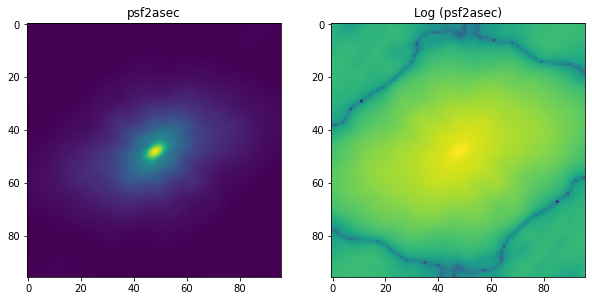

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(img1); ax1.set_title('psf2asec');
ax2.imshow(np.log10(img1)); ax2.set_title('Log (psf2asec)');

# Convolution of a Gaussian Galaxy & PSF using Galsim functions

In [4]:
gal_flux = 1.e5    # total counts on the image
gal_sigma = 2.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30.        # standard deviation of the counts in each pixel

In [5]:
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
psf = galsim.Gaussian(flux=1., sigma=2.)

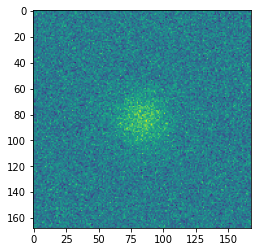

In [6]:
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

plt.imshow(image.array)
plt.show()

# Convolution of the given PSF with a Gaussian Galsim Object (multiplication in Fourier Space)

In [7]:
gal_1 = np.abs(galsim.Gaussian(flux=gal_flux, sigma=gal_sigma).drawImage(nx=96, ny=96).array)
psf_img1 = galsim.Image(img1, copy=True).array

gal_1 /= np.sum(gal_1)
psf_img1 /= np.sum(psf_img1)

Dimensions - (96, 96) (96, 96)


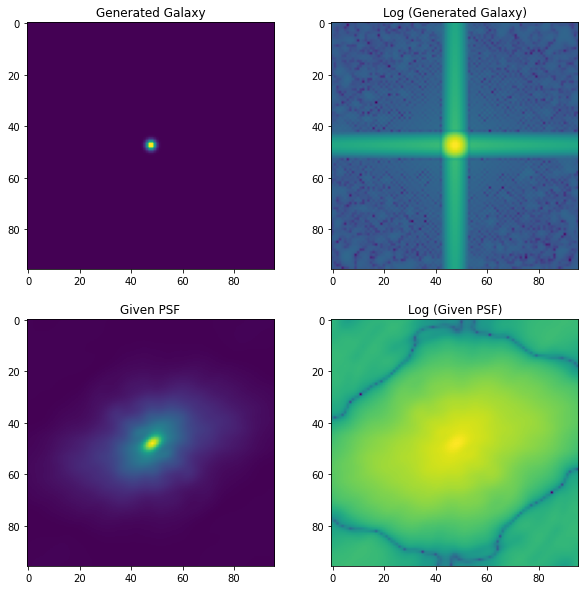

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.imshow(gal_1); ax1.set_title('Generated Galaxy');
ax2.imshow(np.log10(gal_1)); ax2.set_title('Log (Generated Galaxy)');
ax3.imshow(psf_img1); ax3.set_title('Given PSF');
ax4.imshow(np.log10(psf_img1)); ax4.set_title('Log (Given PSF)');

m = gal_1.shape
n = psf_img1.shape
print('Dimensions -', m,n) 

### FFT + Gaussian Noise

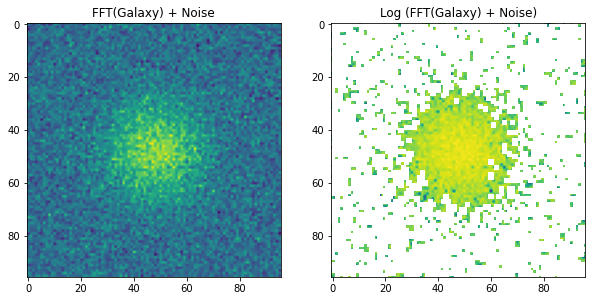

In [9]:
gal_1_fft = np.pad(np.abs(np.fft.fftshift(np.fft.fft2(gal_1))), (abs(m[0]-n[0])//2, abs(m[1]-n[1])//2 ), 'constant')     
psf_img1_fft = np.abs(np.fft.fftshift(np.fft.fft2(psf_img1)))     

# SNR(x) = l2_norm(x)/sigma_noise 

SNR = 1.0e2                                            # Signal to noise ratio in Fourier domain
sigma_noise = np.linalg.norm(gal_1_fft)/SNR            # Standard deviation of noise

gal_1_fft_GSO = galsim.Image(gal_1_fft, copy=True)       # Stored as GSO
gal_1_fft_GSO.addNoise(galsim.GaussianNoise(sigma = sigma_noise)) 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(gal_1_fft_GSO.array); ax1.set_title('FFT(Galaxy) + Noise');
ax2.imshow(np.log10(gal_1_fft_GSO.array)); ax2.set_title('Log (FFT(Galaxy) + Noise)');

### Convolve with PSF

(1.0, 1.0)

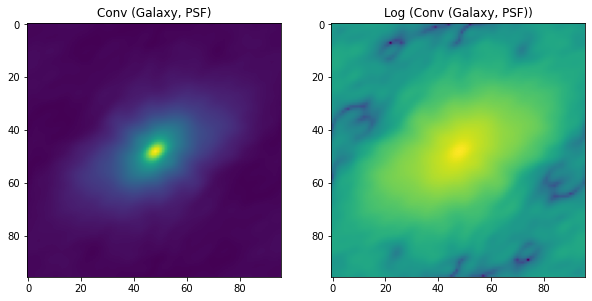

In [10]:
conv1 = np.multiply(gal_1_fft_GSO.array, psf_img1_fft)

final_gal = np.abs(np.fft.ifftshift(np.fft.ifft2(conv1)))                 # IFFT to get back to brightness domain
final_gal *= (np.sum(gal_1)/np.sum(final_gal))                            # Normalisation

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
ax1.imshow(final_gal); ax1.set_title('Conv (Galaxy, PSF)');
ax2.imshow(np.log10(final_gal)); ax2.set_title('Log (Conv (Galaxy, PSF))');

np.sum(gal_1), np.sum(final_gal)

# FISTA

In [11]:
# Utility Functions

def fftconvolve(image, kernel):

    x = np.fft.fftshift(np.fft.fftn(image))
    y = np.fft.fftshift(np.fft.fftn(kernel))

    return np.real(np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(x * y))))

def l1_norm(signal):

    return np.sum(np.abs(signal))


def sigma_mad(signal):

    return 1.4826 * np.median(np.abs(signal - np.median(signal)))


def fft(data):

    return (1 / np.sqrt(data.size) *
            np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(data))))


def ifft(data):

    return (np.sqrt(data.size) *
            np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(data))))


def soft_thresh(data, threshold):

    return np.around(np.maximum((1.0 - threshold /
                     np.maximum(np.finfo(np.float64).eps,
                                np.abs(data))), 0.0) * data,
                     decimals=15)


def nmse(signal_1, singal_2):

    return (np.linalg.norm(singal_2 - signal_1) ** 2 /
            np.linalg.norm(signal_1) ** 2)

In [12]:
def proj(xi):
    
    xi = np.maximum(xi,0)
    return xi


# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)

# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, np.rot90(psf, 2))


# The gradient
def grad(y, alpha_rec, psf):

    return ifft(Ht(H(fft(alpha_rec), psf) - y, psf))


# The cost function
def cost_func(y, alpha_rec, psf, lambda_):

    return (0.5 * np.linalg.norm(y - H(fft(alpha_rec), psf)) ** 2 + lambda_ * np.linalg.norm(alpha_rec))




def runFISTA(observation, first_guess, psf, grad, lambda_val, n_iter=300, gamma=1.0, ST_lambda=1e-10):
    
    cost = []
    nmse_arr = np.zeros(n_iter)
    x_opt = np.zeros(observation.shape)
    count = 0
    
    # FISTA Parameters
    t_k = 1
    alpha_rec = first_guess
    xk = alpha_rec
    
            
    for i in range(n_iter):
        
        # FISTA Update
        
        x_k1 = xk
        alpha_temp = alpha_rec - gamma*grad(observation, alpha_rec, psf)
        alpha_temp = soft_thresh(alpha_temp, ST_lambda)
        xk = proj(alpha_temp)
        t_k1 = (1 + np.sqrt(1 + 4*t_k**2))/2
        alpha_rec = xk + (t_k - 1)/t_k1*(xk - x_k1)
        t_k = t_k1
                
        
        cost.append(cost_func(observation, alpha_rec, psf, lambda_val))
        
    
        
        # Convert back to signal domain
        x_rec = np.abs(fft(alpha_rec))
        nmse_arr[i] = nmse(gal_1, x_rec)
        
        
        if (i!=0) and (nmse_arr[i]<nmse_arr[i-1]) and count==0:
            x_opt = x_rec
        elif (i!=0) and (nmse_arr[i]>nmse_arr[i-1]):
            count += 1
        
        
        if i%100==0 and i!=0:
            
            fig = plt.subplots(1,3, figsize=(25,25))
            
            plt.subplot(131)
            plt.title('Reconstruction after {} iterations'.format(i))
            ax1 = plt.gca()
            im1 = ax1.imshow(x_rec)
            divider = make_axes_locatable(ax1)
            cax1 = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im1, cax=cax1)

            plt.subplot(132)
            plt.title('Log Scale Intensity')
            plt.imshow(np.log10(x_rec))

            plt.subplot(133)
            plt.title('Intensity Plot (Central Slice)')
            ax3 = plt.gca()
            ax3.plot(x_rec[48,:], label='rec_im')           
            ax3.plot(gal_1[48,:], label='gal')  
            plt.legend()
            ax3.set_aspect(1.0/ax3.get_data_ratio())
            
            plt.show(fig)
    
    return x_rec, x_opt, nmse_arr, cost

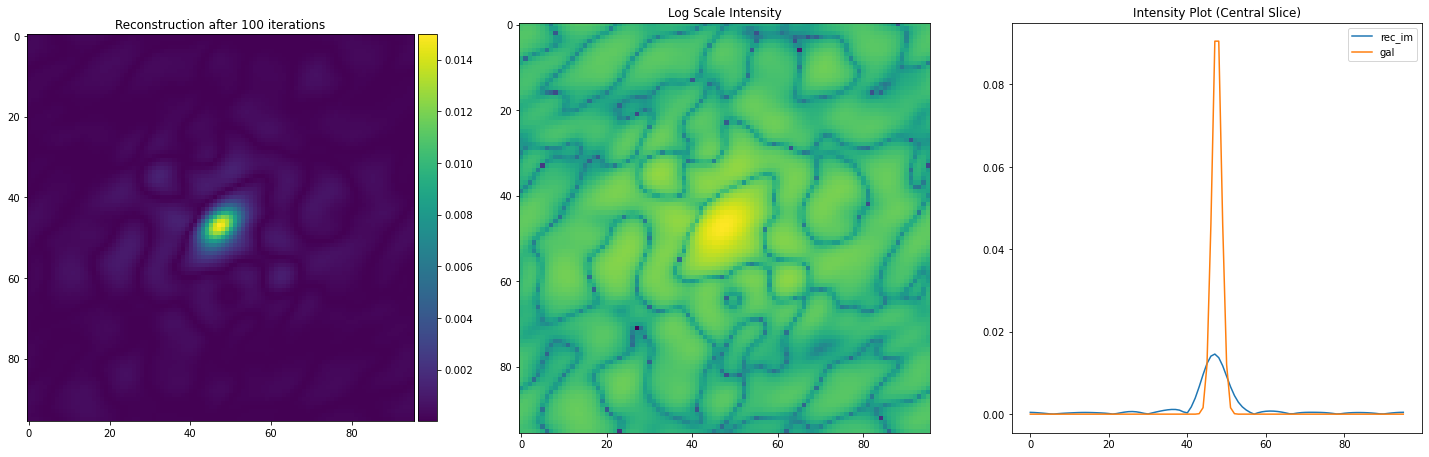

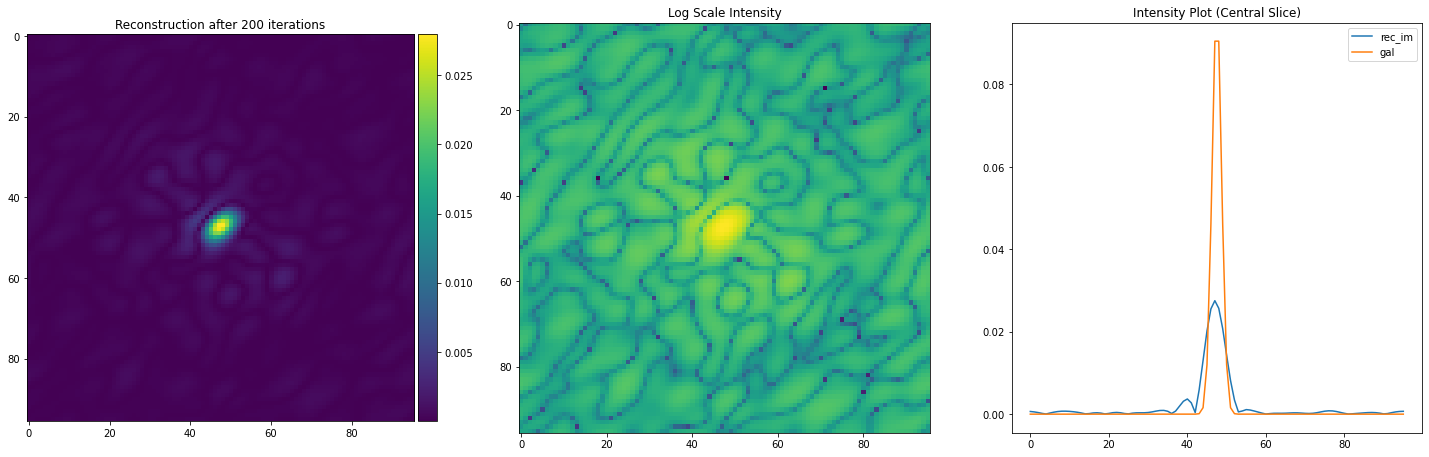

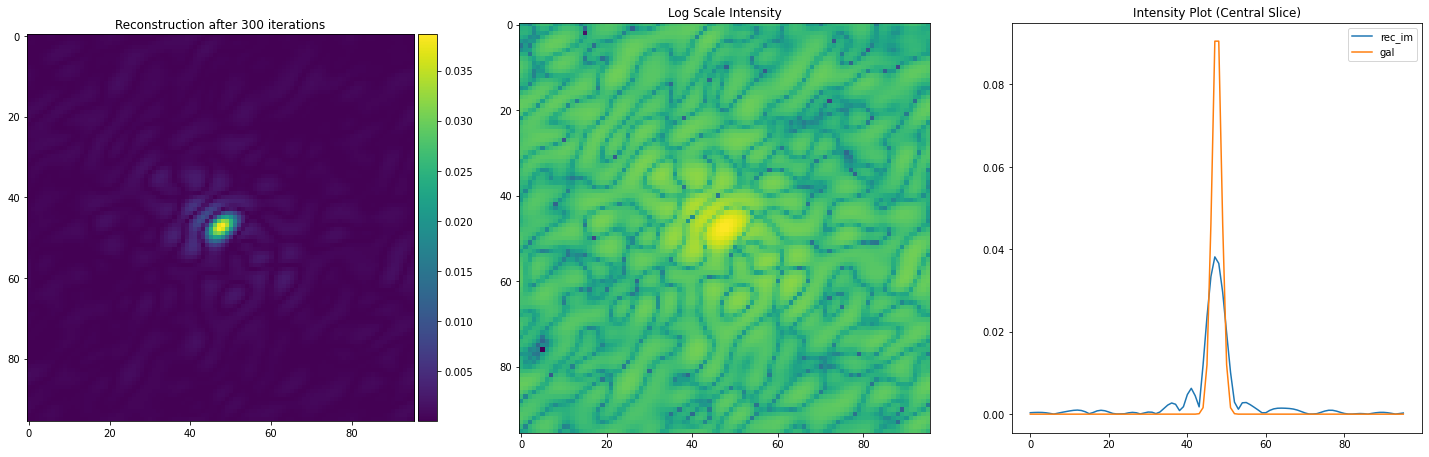

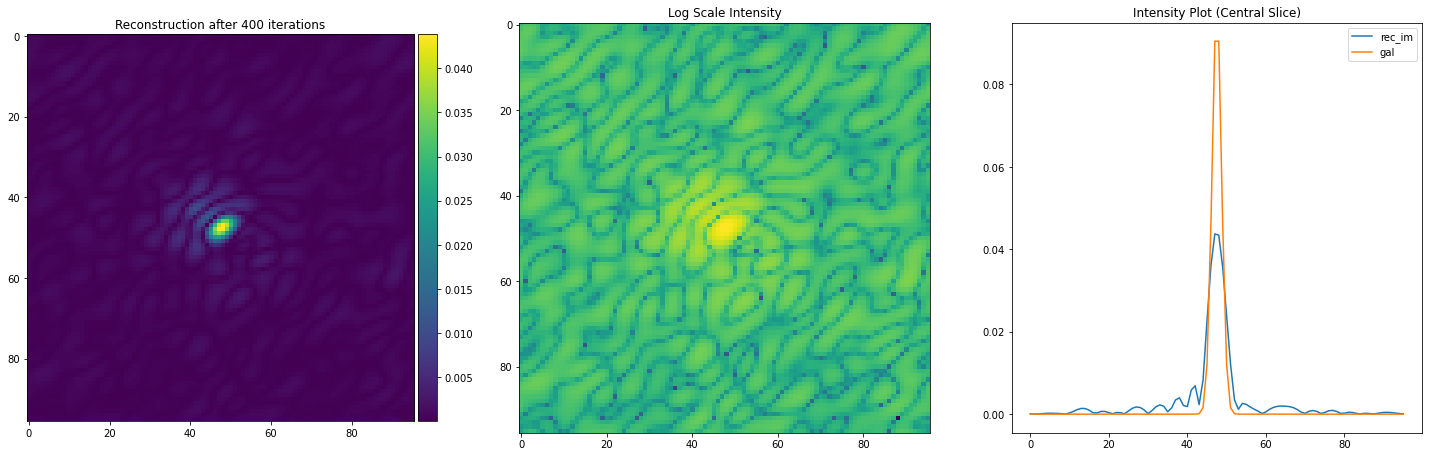

In [13]:
# Number of Iterations
n_iter = 500             # Diverges beyongd 500-600

# Deconvolve the image
x_rec, x_opt, nmse_arr, cost = runFISTA(final_gal, np.zeros(final_gal.shape), psf_img1, grad, 
                                        lambda_val=1e-4, n_iter=n_iter)

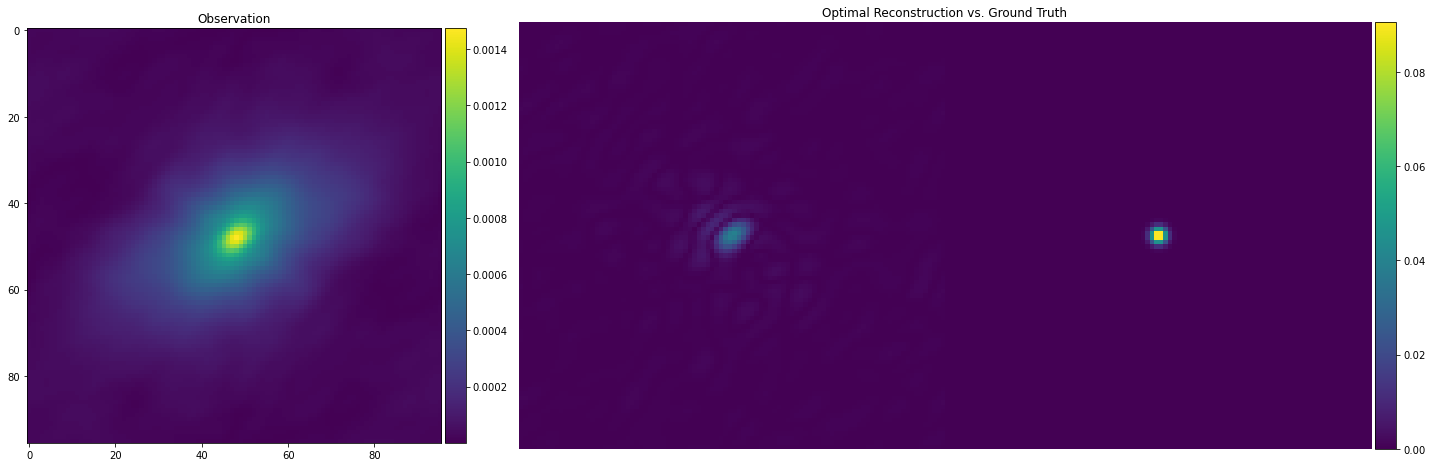

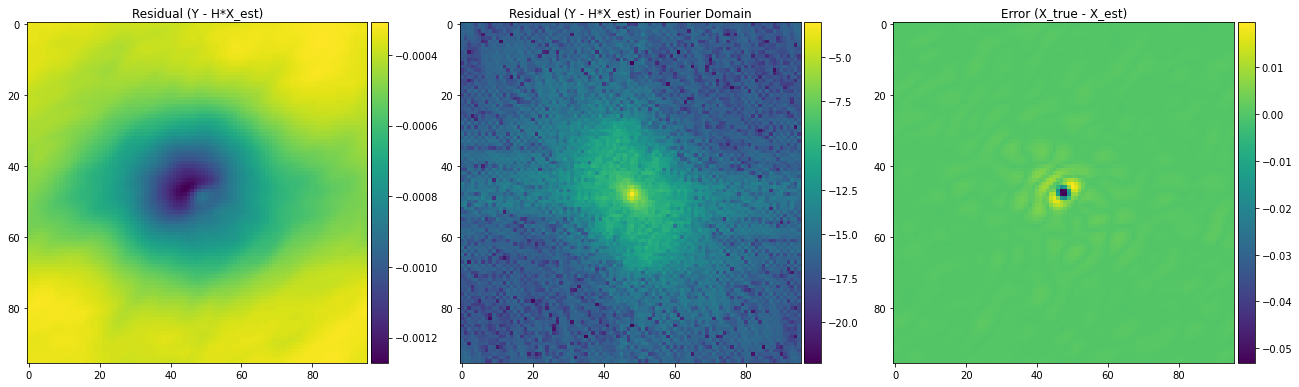

In [14]:
# Comparison

temp = np.concatenate((x_opt, gal_1), 1)

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 

ax1 = plt.subplot(gs[0])
plt.title('Observation')
ax1 = plt.gca()
im1 = ax1.imshow(final_gal)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

ax2 = plt.subplot(gs[1])
plt.title('Optimal Reconstruction vs. Ground Truth')
ax2.imshow(temp)
ax2 = plt.gca()
im2 = ax2.imshow(temp)
ax2.axis('off')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.tight_layout()


fig2 = plt.subplots(1,3, figsize=(22,22))
plt.subplot(131)
plt.title('Residual (Y - H*X_est)')
ax1 = plt.gca()
im1 = ax1.imshow(final_gal - fftconvolve(psf_img1, x_opt))
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

plt.subplot(132)
plt.title('Residual (Y - H*X_est) in Fourier Domain')
ax2 = plt.gca()
im2 = ax2.imshow(np.log(np.abs(fft(final_gal - fftconvolve(psf_img1, x_opt)))))
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

plt.subplot(133)
plt.title('Error (X_true - X_est)')
ax3 = plt.gca()
im3 = ax3.imshow(x_opt - gal_1)
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)

plt.show(fig2)

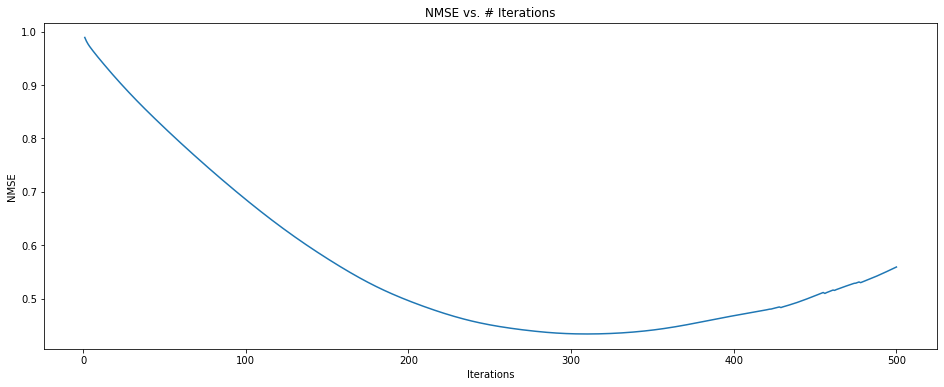


Minimum NMSE = 0.43408753558623187 (at 309 iterations)


In [15]:
min_nmse = np.min(nmse_arr)
min_iter = np.where(nmse_arr == min_nmse)[0][0]

fig3, ax3 = plt.subplots(1,1, figsize=(16,6))
ax3.plot(np.arange(1,n_iter+1), nmse_arr); ax3.set_title('NMSE vs. # Iterations');
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.show(fig3)
print('\nMinimum NMSE = {} (at {} iterations)'.format(min_nmse, min_iter))